In [1]:
from pyspark.sql import functions as F
from modules.spark import spark

In [2]:
df = spark.read.csv('../data/processed/data-with-relevant-columns.csv', header=True, inferSchema=True)

In [3]:
df.printSchema()

root
 |-- Type: string (nullable = true)
 |-- ShippingMode: string (nullable = true)
 |-- ProductPrice: double (nullable = true)
 |-- LateDeliveryRisk: integer (nullable = true)
 |-- CategoryName: string (nullable = true)
 |-- CustomerSegment: string (nullable = true)
 |-- OrderItemQuantity: integer (nullable = true)
 |-- OrderRegion: string (nullable = true)
 |-- ShippingMonthName: string (nullable = true)



### Visualiser les données.

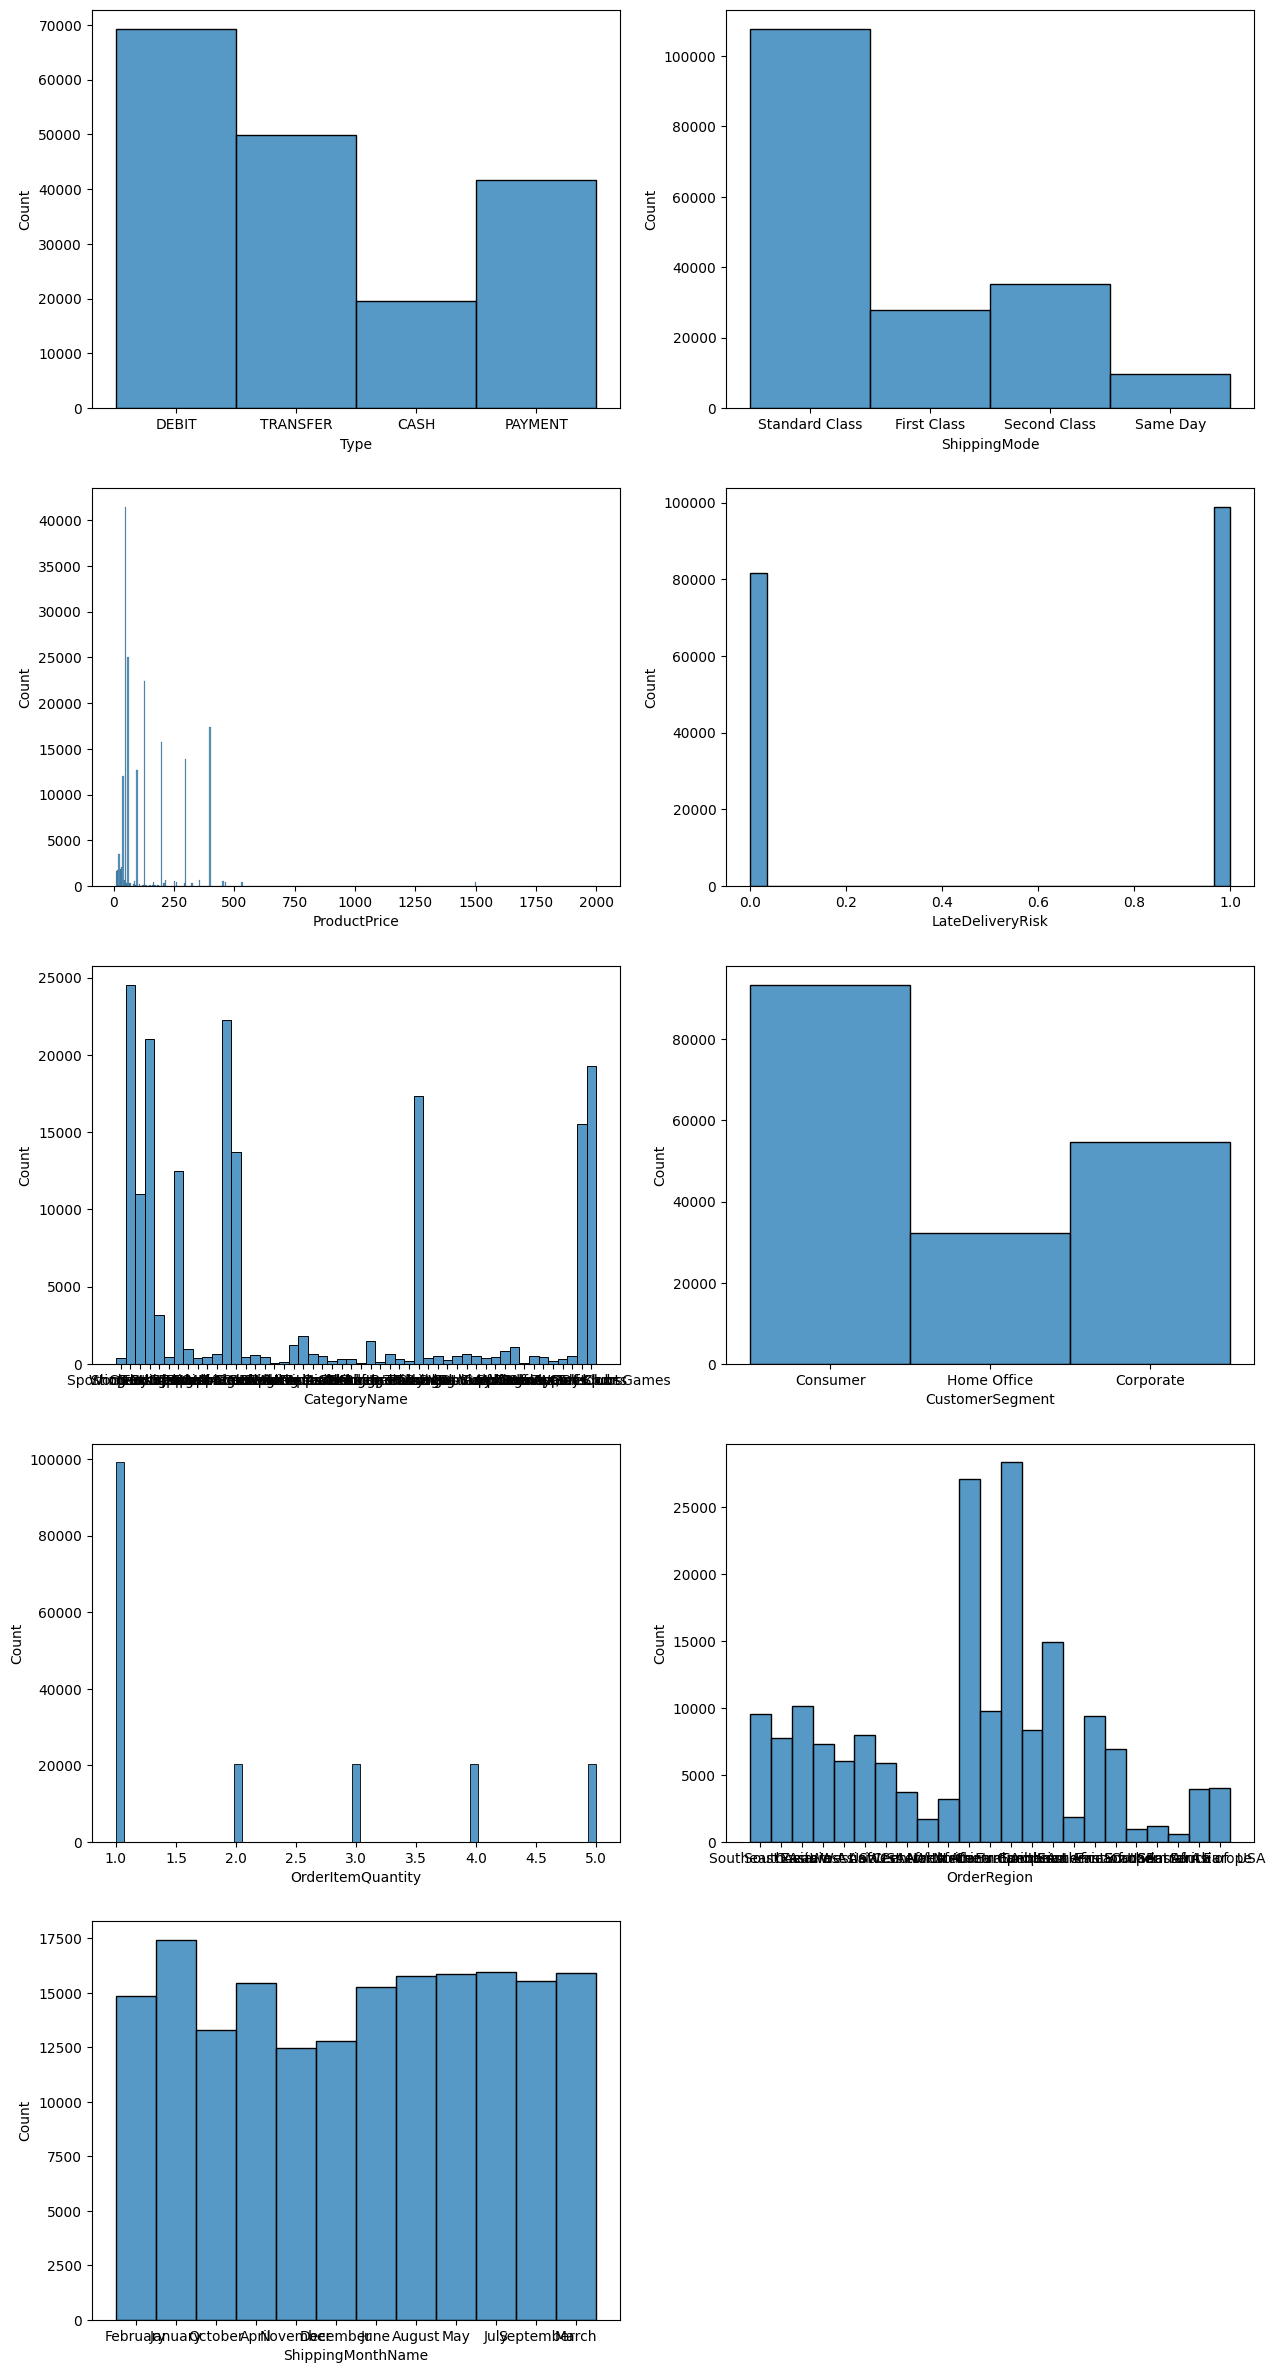

In [13]:
import matplotlib.pyplot as plt
import seaborn as sb

pdf = df.toPandas()

i = 1
plt.figure(figsize=(15, 30))

for col in pdf.columns:
    plt.subplot(5, 2, i)
    sb.histplot(data=pdf, x=col)

    i += 1

plt.show()

### Analyser les statistiques.

In [ ]:
df.select("ProductPrice", "OrderItemQuantity").describe().show()

+-------+--------+--------------+------------------+-------------------+------------------+---------------+-----------------+--------------+-----------------+
|summary|    Type|  ShippingMode|      ProductPrice|   LateDeliveryRisk|      CategoryName|CustomerSegment|OrderItemQuantity|   OrderRegion|ShippingMonthName|
+-------+--------+--------------+------------------+-------------------+------------------+---------------+-----------------+--------------+-----------------+
|  count|  180519|        180519|            180519|             180519|            180519|         180519|           180519|        180519|           180519|
|   mean|    NULL|          NULL|141.23254992873387| 0.5482913155955883|              NULL|           NULL|2.127637533999191|          NULL|             NULL|
| stddev|    NULL|          NULL|139.73249200374272|0.49766386328809165|              NULL|           NULL|1.453451481422639|          NULL|             NULL|
|    min|    CASH|   First Class|       9.9899

In [20]:
for col in ["Type", "ShippingMode", "LateDeliveryRisk", "CategoryName", "CustomerSegment", "OrderRegion", "ShippingMonthName"]:
    print(col)
    df.groupBy(col).count().orderBy(F.col("count").desc()).show()

Type
+--------+-----+
|    Type|count|
+--------+-----+
|   DEBIT|69295|
|TRANSFER|49883|
| PAYMENT|41725|
|    CASH|19616|
+--------+-----+

ShippingMode
+--------------+------+
|  ShippingMode| count|
+--------------+------+
|Standard Class|107752|
|  Second Class| 35216|
|   First Class| 27814|
|      Same Day|  9737|
+--------------+------+

LateDeliveryRisk
+----------------+-----+
|LateDeliveryRisk|count|
+----------------+-----+
|               1|98977|
|               0|81542|
+----------------+-----+

CategoryName
+--------------------+-----+
|        CategoryName|count|
+--------------------+-----+
|              Cleats|24551|
|      Men's Footwear|22246|
|     Women's Apparel|21035|
|Indoor/Outdoor Games|19298|
|             Fishing|17325|
|        Water Sports|15540|
|    Camping & Hiking|13729|
|    Cardio Equipment|12487|
|       Shop By Sport|10984|
|         Electronics| 3156|
|         Accessories| 1780|
|          Golf Balls| 1475|
|      Girls' Apparel| 1201|
|      

In [32]:
# Approximate quantiles: faster and scalable
quantiles = df.approxQuantile("ProductPrice", [0.25, 0.75], 0.0)
Q1, Q3 = quantiles
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_outliers = df.withColumn(
    "is_outlier",
    F.when((F.col("ProductPrice") < lower_bound) | (F.col("ProductPrice") > upper_bound), 1).otherwise(0)
)

- Number of outliers

In [33]:
df_outliers.filter(F.col('is_outlier') == 1).count()

2048

- Remove outliers

In [34]:
df_cleaned = df_outliers.filter(F.col('is_outlier') == 0)

In [38]:
df_cleaned.count()

178471

- Sauvegardez le modéle

In [37]:
df_cleaned.write.csv('../data/processed/data-cleaned', header=True)